# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `figure8_sdv.ipynb` from `6_sdv_swe_new_norm.ipynb`
### Including only the code required to make figure svd, from notebook `6_sdv_steven_edits.ipynb`

created by Cassie Lumbrazo\
last updated: July 2025\
run location: UAS Linux\
python environment: **cer_treatment**

In [3]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
# ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc') # Steven's path
# ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') # Cassie local path
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

---

In [5]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

In [6]:
# Constants 
# colors
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

colorcontrol = 'black'
colortreatment = 'saddlebrown'

# colorcontrol = 'dimgray'
colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'
colortreatment2 = 'darkslategrey'

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

### Add Code from `11_delta_dce_categories.ipynb` to normalize snow depth the same way as we do for the delta dce

In [7]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Most Forested (ncalm negative, rapid negative, delta DCE negative) forest to denser forest
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: More Forested (ncalm negative, rapid negative, delta DCE positive) forest to edge 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5)) no change 
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Less Open (ncalm positive, rapid less than ncalm) open to less open 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: More Open (ncalm positive, rapid greater than ncalm) open to more open 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Most Open (ncalm negative, rapid positive) forest to open 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

In [8]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [9]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

### Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [10]:
ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

Now, do the same calculation for thenew normalized methods (same as the deltaDCE)

In [11]:
# Now, redo that code but with the new normalized snow depth values from delta DCE 
ds['sdv_rapid_new_norm'] = (ds['hs_rapid_zeros_removed'] - mean_2023) / std_2023 # those mean and std are calculated above with detla DCE
ds['sdv_ncalm_new_norm'] = (ds['hs_ncalm_zeros_removed'] - mean_2021) / std_2021 # those mean and std are calculated above with delta DCE

ds['diff_sdv_rapid_ncalm_new_norm'] = (ds['sdv_rapid_new_norm'] - ds['sdv_ncalm_new_norm']) # 2023 SDV - 2021 SDV

In [12]:
# print the mean and standard deviations used to calculate 
print('Mean HS RAPID:', ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y']).values)
print('Mean HS NCALM:', ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y']).values)
print('STD HS RAPID:', ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y']).values)
print('STD HS NCALM:', ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y']).values)

Mean HS RAPID: [0.39387816]
Mean HS NCALM: [0.33291218]
STD HS RAPID: [0.22906527]
STD HS NCALM: [0.28451866]


In [13]:
# print the median values 
print(f'median south: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).median().values)
print(f'median north: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).median().values)

# print the median values with the new normalized sdv diff
print(f'median south new norm: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).median().values)
print(f'median north new norm: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).median().values)

median south:  0.108297125
median north:  0.12858474
median south new norm:  0.37010223
median north new norm:  0.2226932


Now, just look at treatment and control across the ridge, 

In [14]:
ds['sdv_diff_treatment'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf))
ds['sdv_diff_control']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf))

ds['sdv_diff_treatment_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf))
ds['sdv_diff_control_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf))

In [15]:
# print the medians from the plot 
print(f'median treatment: ', ds['sdv_diff_treatment'].median().values)
print(f'median control: ', ds['sdv_diff_control'].median().values)

# print the medians from the plot with the new normalized sdv diff
print(f'median treatment new norm: ', ds['sdv_diff_treatment_new_norm'].median().values)
print(f'median control new norm: ', ds['sdv_diff_control_new_norm'].median().values)

median treatment:  0.15693569
median control:  -0.0140082985
median treatment new norm:  0.35993037
median control new norm:  0.1828331


Now, north and south by treated and untreated areas

In [16]:
# for the treatment and control, north and south
ds['sdv_diff_treatment_south'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

# for the treatment and control, north and south with the new normalized sdv diff
ds['sdv_diff_treatment_south_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

Print the medians, 

In [17]:
# print the medians, for the first sdv diff
print(f'median control south: ', ds['sdv_diff_control_south'].median().values)
print(f'median treatment south: ', ds['sdv_diff_treatment_south'].median().values)
print(f'median control north: ', ds['sdv_diff_control_north'].median().values)
print(f'median treatment north: ', ds['sdv_diff_treatment_north'].median().values)


# print the medians, for the new normalized sdv diff
print(f'median control south new norm: ', ds['sdv_diff_control_south_new_norm'].median().values)
print(f'median treatment south new norm: ', ds['sdv_diff_treatment_south_new_norm'].median().values)
print(f'median control north new norm: ', ds['sdv_diff_control_north_new_norm'].median().values)
print(f'median treatment north new norm: ', ds['sdv_diff_treatment_north_new_norm'].median().values)

median control south:  0.14517897
median treatment south:  0.096662045
median control north:  -0.27967072
median treatment north:  0.262797
median control south new norm:  0.38717398
median treatment south new norm:  0.3648748
median control north new norm:  -0.19350524
median treatment north new norm:  0.35081443


# Figure 8 SVD

### First, left side of Figure 8

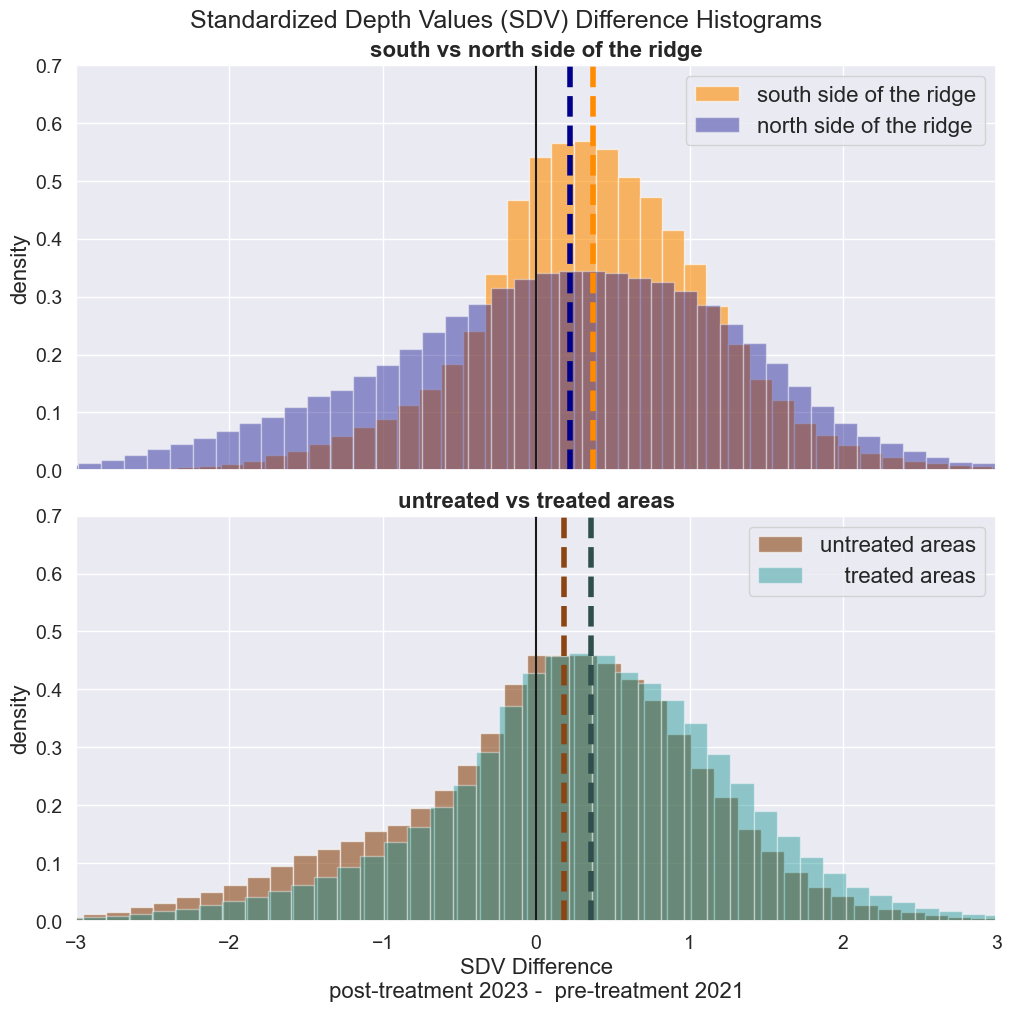

In [31]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)

ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.6, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.4, density=True, label='north side of the ridge');
ds['sdv_diff_control_new_norm'].plot.hist(  ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_new_norm'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=4, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_control_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_treatment_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=4, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 16)
axes[1].legend(fontsize = 16)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 16)
axes[1].set_ylabel('density', fontsize = 16)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021', fontsize=16)

plt.suptitle('Standardized Depth Values (SDV) Difference Histograms', fontsize=18)

axes[0].set_title('south vs north side of the ridge', fontsize = 16, fontweight = 'bold')
axes[1].set_title('untreated vs treated areas', fontsize = 16, fontweight = 'bold')

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)

# export the figure with high resolution
figure_name = 'figure8_sdv_left.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

### Right side of Figure 8, 

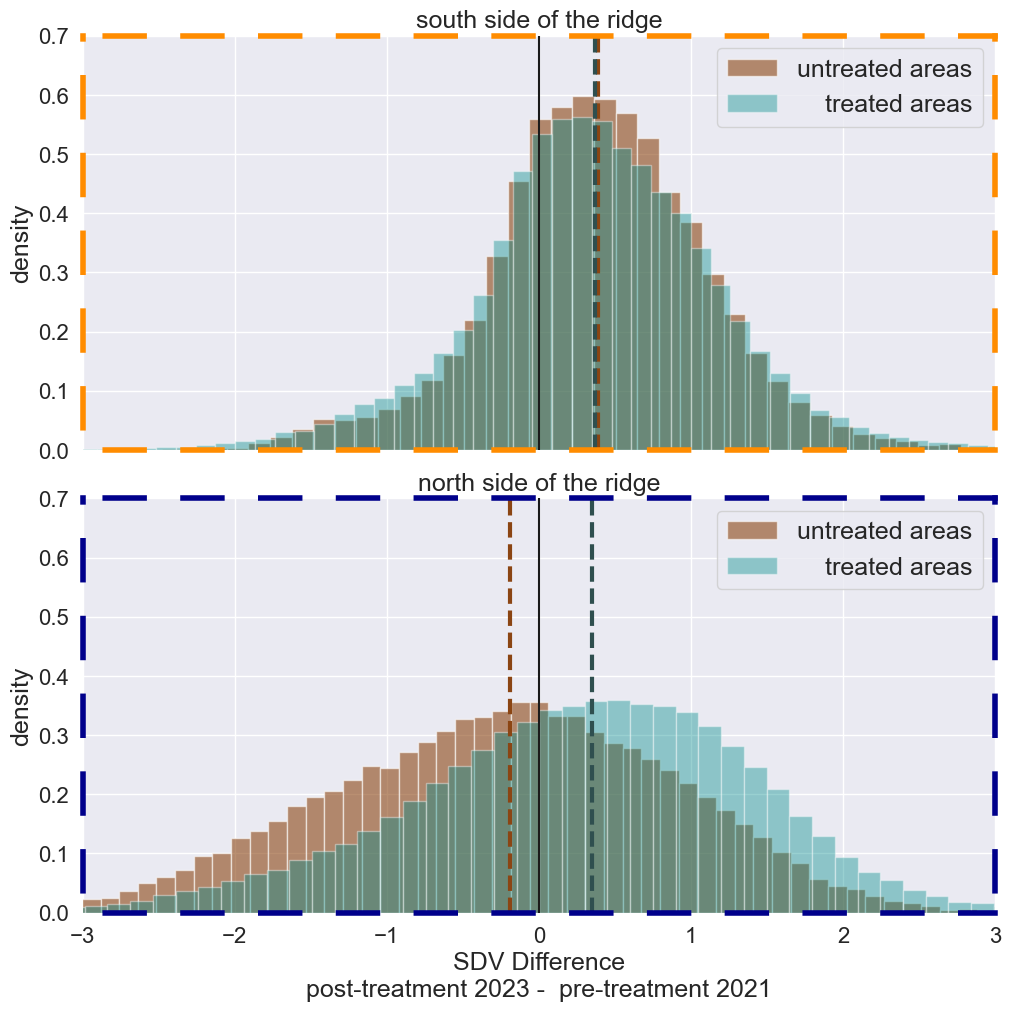

In [30]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)
ds['sdv_diff_control_south_new_norm'].plot.hist(ax=axes[0], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_south_new_norm'].plot.hist(ax=axes[0], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');
ds['sdv_diff_control_north_new_norm'].plot.hist(ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_north_new_norm'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['sdv_diff_control_south_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['sdv_diff_treatment_south_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_control_north_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_treatment_north_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 18)
axes[1].legend(fontsize = 18)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 18)
axes[1].set_ylabel('density', fontsize = 18)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021', fontsize=18)

# plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')

axes[0].set_title('south side of the ridge', fontsize = 18)
axes[1].set_title('north side of the ridge', fontsize = 18)

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)

# make an orange outline on the first subplot 
for spine in axes[0].spines.values():
    spine.set_edgecolor(colorsouth)
    spine.set_linewidth(4)
    # spine.set_linestyle('dashed')
    spine.set_linestyle((10, (7,7))) # line width, then (points, gap)
    
# make a blue outline on the second subplot
for spine in axes[1].spines.values():
    spine.set_edgecolor(colornorth)
    spine.set_linewidth(4)
    spine.set_linestyle((10, (7,7)))
    
# # add a C) and D) to the subplots 
# axes[0].text(0.01, 0.9, 'C)', fontsize=18, transform=axes[0].transAxes)
# axes[1].text(0.01, 0.9, 'D)', fontsize=18, transform=axes[1].transAxes)

# export the figure with high resolution
figure_name = 'figure8_sdv_right.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

### Print the median and standard deviations for all the groups

In [ ]:
# print the mean and standard deviation for all the groups plotted above
print("All values are for the new normalized SDV difference")
print(f'mean south: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).mean().values)
print(f'mean north: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).mean().values)
print(f'mean control: ', ds['sdv_diff_control_new_norm'].mean().values)
print(f'mean treatment: ', ds['sdv_diff_treatment_new_norm'].mean().values)

print(f'std south: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).std().values)
print(f'std north: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).std().values)
print(f'std control: ', ds['sdv_diff_control_new_norm'].std().values)
print(f'std treatment: ', ds['sdv_diff_treatment_new_norm'].std().values)

# print the mean and standard deviation for the south and north side of the ridge
print(f'mean control south: ', ds['sdv_diff_control_south_new_norm'].mean().values)
print(f'mean treatment south: ', ds['sdv_diff_treatment_south_new_norm'].mean().values)
print(f'mean control north: ', ds['sdv_diff_control_north_new_norm'].mean().values)
print(f'mean treatment north: ', ds['sdv_diff_treatment_north_new_norm'].mean().values)

print(f'std control south: ', ds['sdv_diff_control_south_new_norm'].std().values)
print(f'std treatment south: ', ds['sdv_diff_treatment_south_new_norm'].std().values)
print(f'std control north: ', ds['sdv_diff_control_north_new_norm'].std().values)
print(f'std treatment north: ', ds['sdv_diff_treatment_north_new_norm'].std().values)

All values are for the new normalized SDV difference
mean south:  0.38453674
mean north:  0.16034497
mean control:  0.096552886
mean treatment:  0.33315647
std south:  0.8214593
std north:  1.1625133
std control:  1.0292339
std treatment:  0.98989457
mean control south:  0.40438542
mean treatment south:  0.37865835
mean control north:  -0.23271543
mean treatment north:  0.28220636
std control south:  0.7784617
std treatment south:  0.8336773
std control north:  1.1551763
std treatment north:  1.1375235


Only the new normalized code is plotted above, so below is the commented out code to get the values for the previous normalized SDV diff

In [24]:
# # print the mean and standard deviation for all the groups plotted above 
# print("All values are for the previous SDV difference")
# print(f'mean south: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).mean().values)
# print(f'mean north: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).mean().values)
# print(f'mean control: ', ds['sdv_diff_control'].mean().values)
# print(f'mean treatment: ', ds['sdv_diff_treatment'].mean().values)

# print(f'std south: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).std().values)
# print(f'std north: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).std().values)
# print(f'std control: ', ds['sdv_diff_control'].std().values)
# print(f'std treatment: ', ds['sdv_diff_treatment'].std().values)

# # print the mean and standard deviation for the south and north side of the ridge
# print(f'mean control south: ', ds['sdv_diff_control_south'].mean().values)
# print(f'mean treatment south: ', ds['sdv_diff_treatment_south'].mean().values)
# print(f'mean control north: ', ds['sdv_diff_control_north'].mean().values)
# print(f'mean treatment north: ', ds['sdv_diff_treatment_north'].mean().values)

# print(f'std control south: ', ds['sdv_diff_control_south'].std().values)
# print(f'std treatment south: ', ds['sdv_diff_treatment_south'].std().values)
# print(f'std control north: ', ds['sdv_diff_control_north'].std().values)
# print(f'std treatment north: ', ds['sdv_diff_treatment_north'].std().values)